# N9_4C: MaxEnt RL in a 2D Multi‑Goal Environment (improved action panels)

This notebook is a **CPU-friendly didactic** re-creation of the “2D multi-goal” illustration (Fig. 1) from:

- T. Haarnoja, H. Tang, P. Abbeel, S. Levine, *Reinforcement Learning with Deep Energy-Based Policies*, arXiv:1702.08165 (2017).

Compared to the previous draft, this version adds a **quadratic action cost** (energy penalty) to the soft \(Q\),
which prevents the “always max-speed” artifact and makes **multi-modality in action space** visually clearer.

## Outputs (saved as PNG into `figs/`)
- `agentic_multigoal_trajectories.png`
- `agentic_multigoal_Q_slices.png`
- `agentic_multigoal_Fig1_like.png`  *(recommended composite for the book)*


## 0. Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

FIG_DIR = "figs"
os.makedirs(FIG_DIR, exist_ok=True)

rng = np.random.default_rng(0)
print("Using FIG_DIR =", os.path.abspath(FIG_DIR))


Using FIG_DIR = /Users/chertkov/Dropbox/Apps/Overleaf/MathGenAIBook/notebooks-new/Synthesis/figs


## 1. Multi-goal reward + soft (MaxEnt) policy (didactic)

State $s=(x,y)\in\mathbb{R}^2$.  
Action $a=(a_x,a_y)\in[-1,1]^2$ is a bounded velocity command.

Dynamics:
$$
s_{t+1}=s_t + \Delta t\, a_t.
$$

Reward (mixture of Gaussians) centered at four symmetric goals \(g_i\):
$$
r(s)=\sum_{i=1}^4 \exp\!\Big(-\tfrac{\|s-g_i\|^2}{2\sigma^2}\Big).
$$

Surrogate one-step soft \(Q\) with **action cost**:
$$
Q(s,a)= r(s') + \gamma\,V_{\text{proxy}}(s') \;-\;\tfrac{\lambda}{2}\|a\|^2,
\qquad s'=s+\Delta t\,a.
$$

Gibbs policy:
$$
\pi(a\mid s)\propto \exp(Q(s,a)/\alpha).
$$


In [6]:
# -----------------------------
# Environment / MaxEnt settings
# -----------------------------
goals = np.array([
    [ 5.0,  0.0],
    [-5.0,  0.0],
    [ 0.0,  5.0],
    [ 0.0, -5.0],
], dtype=float)

sigma = 1.2
dt = 0.55
gamma = 0.90

alpha = 0.25      # smaller => sharper modes (but still stochastic)
lam = 1.2         # action-cost strength (key for clean action plots)

T = 60
N_traj = 60

# Discretize action space [-1,1]^2
na = 41
a1 = np.linspace(-1.0, 1.0, na)
AX, AY = np.meshgrid(a1, a1, indexing="xy")
A_grid = np.stack([AX.ravel(), AY.ravel()], axis=1)   # (na^2, 2)

def reward(s):
    s = np.asarray(s)
    d2 = np.sum((s[..., None, :] - goals[None, ...])**2, axis=-1)  # (...,4)
    return np.sum(np.exp(-0.5 * d2 / (sigma**2)), axis=-1)          # (...)

def V_proxy(s):
    # smooth log-sum-exp potential over goals (purely shaping; no training)
    s = np.asarray(s)
    sigV = 2.4
    beta = 1.0
    d2 = np.sum((s[..., None, :] - goals[None, ...])**2, axis=-1)
    x = -beta * 0.5 * d2 / (sigV**2)
    m = np.max(x, axis=-1, keepdims=True)
    lse = m[..., 0] + np.log(np.sum(np.exp(x - m), axis=-1))
    return lse

def Q_soft(s, a):
    s = np.asarray(s)
    a = np.asarray(a)
    sp = s + dt * a
    q = reward(sp) + gamma * V_proxy(sp)
    q = q - 0.5 * lam * np.sum(a*a, axis=-1)
    return q

def softmax(logits):
    z = logits - np.max(logits)
    w = np.exp(z)
    return w / np.sum(w)

def sample_action_gibbs(s, rng):
    q = Q_soft(s[None, :], A_grid).reshape(-1)
    probs = softmax(q / alpha)
    idx = rng.choice(len(probs), p=probs)
    return A_grid[idx], probs, q

print("Action grid size:", A_grid.shape[0])
print("Reward at origin:", float(reward(np.array([0.0,0.0]))))
print("Hyperparams: alpha =", alpha, "| lam =", lam, "| dt =", dt)


Action grid size: 1681
Reward at origin: 0.0006794267062456427
Hyperparams: alpha = 0.25 | lam = 1.2 | dt = 0.55


## 2. Figure A: trajectories on the reward landscape

Roll out the Gibbs policy from the origin.  
Because the goals are symmetric, MaxEnt control produces **diverse trajectories** (mode coverage).


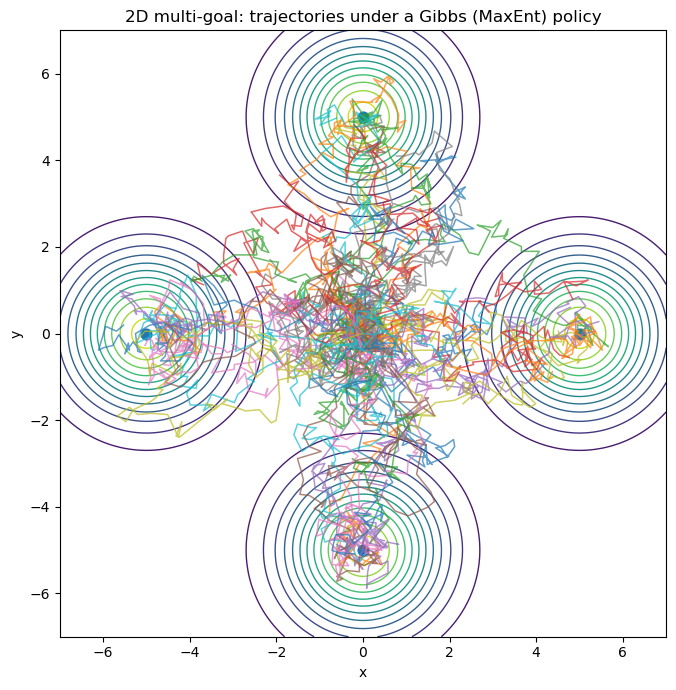

Saved: figs/agentic_multigoal_trajectories.png


In [7]:
# Roll out trajectories
s0 = np.array([0.0, 0.0])

trajectories = []
for k in range(N_traj):
    s = s0.copy()
    traj = [s.copy()]
    for t in range(T):
        a, _, _ = sample_action_gibbs(s, rng)
        s = s + dt * a
        traj.append(s.copy())
    trajectories.append(np.array(traj))

# Reward contour background
xlim = (-7.0, 7.0)
ylim = (-7.0, 7.0)
nx = 240
xx = np.linspace(xlim[0], xlim[1], nx)
yy = np.linspace(ylim[0], ylim[1], nx)
XX, YY = np.meshgrid(xx, yy, indexing="xy")
Sgrid = np.stack([XX, YY], axis=-1)
R = reward(Sgrid)

fig = plt.figure(figsize=(7.6, 7.0))
ax = fig.add_subplot(1,1,1)
ax.contour(XX, YY, R, levels=14, linewidths=1.0)
ax.scatter(goals[:,0], goals[:,1], marker="o", s=60)
ax.scatter([s0[0]], [s0[1]], marker="x", s=80)

for tr in trajectories:
    ax.plot(tr[:,0], tr[:,1], linewidth=1.1, alpha=0.70)

ax.set_title("2D multi-goal: trajectories under a Gibbs (MaxEnt) policy")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect("equal")
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

outA = os.path.join(FIG_DIR, "agentic_multigoal_trajectories.png")
plt.tight_layout()
plt.savefig(outA, dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", outA)


## 3. Figure B: action-space \(Q(s,a)\) slices at three “between-goals” states

We plot level sets of \(Q(s,a)\) over the action space \([-1,1]^2\) at:
- \(s=(0,0)\) (symmetric, competing goals)
- \(s=(2.2,0)\) (between right and left goals, biased toward the right)
- \(s=(1.8,1.8)\) (between right and up goals)

We overlay sampled actions from \(\pi(a|s)\) (stars).  
With the action penalty, samples should concentrate near **one or two clear modes**, depending on state.


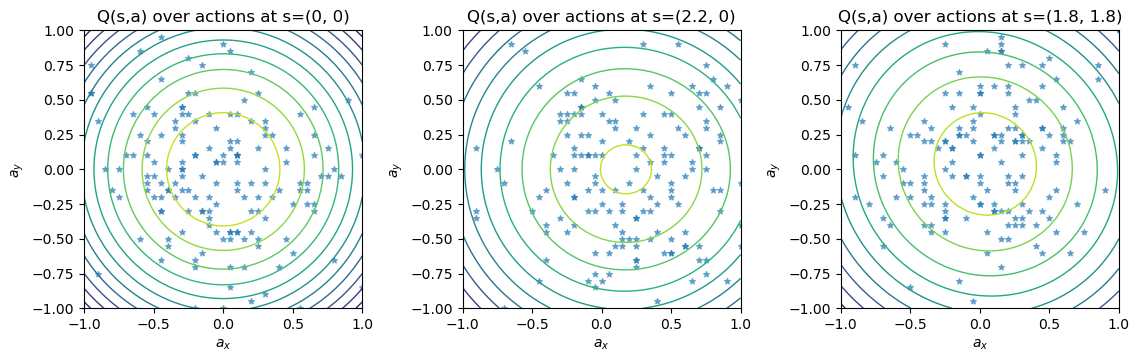

Saved: figs/agentic_multigoal_Q_slices.png


In [8]:
states_to_plot = [
    np.array([0.0, 0.0]),
    np.array([2.2, 0.0]),
    np.array([1.8, 1.8]),
]
state_labels = ["(0, 0)", "(2.2, 0)", "(1.8, 1.8)"]

Qmaps = []
Asamps = []

n_samp = 160
for s in states_to_plot:
    q = Q_soft(s[None,:], A_grid).reshape(na, na)
    Qmaps.append(q)
    samples = []
    for _ in range(n_samp):
        a, _, _ = sample_action_gibbs(s, rng)
        samples.append(a)
    Asamps.append(np.array(samples))

fig = plt.figure(figsize=(11.5, 3.8))
for i, (q, samp, lab) in enumerate(zip(Qmaps, Asamps, state_labels)):
    ax = fig.add_subplot(1, 3, i+1)
    ax.contour(AX, AY, q, levels=12, linewidths=1.0)
    ax.scatter(samp[:,0], samp[:,1], marker="*", s=18, alpha=0.55)
    ax.set_title(f"Q(s,a) over actions at s={lab}")
    ax.set_xlabel(r"$a_x$")
    ax.set_ylabel(r"$a_y$")
    ax.set_xlim(-1.0, 1.0)
    ax.set_ylim(-1.0, 1.0)
    ax.set_aspect("equal")

outB = os.path.join(FIG_DIR, "agentic_multigoal_Q_slices.png")
plt.tight_layout()
plt.savefig(outB, dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", outB)


## 4. Combined “Fig. 1–like” layout (recommended for the book)

This composite is the one you should include in the chapter.


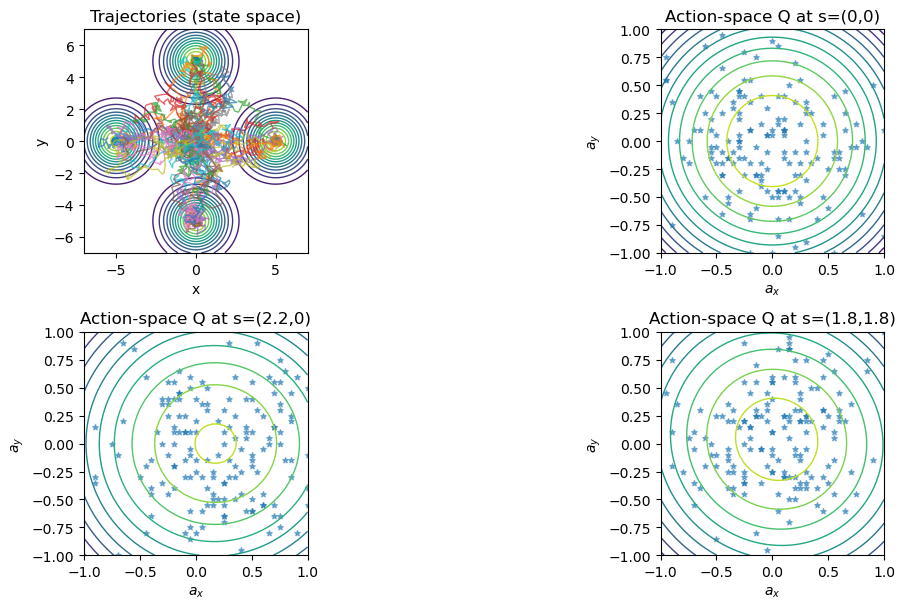

Saved: figs/agentic_multigoal_Fig1_like.png


In [9]:
fig = plt.figure(figsize=(13.5, 6.2))

# Top-left: trajectories in state space
axL = fig.add_subplot(2, 2, 1)
axL.contour(XX, YY, R, levels=14, linewidths=1.0)
axL.scatter(goals[:,0], goals[:,1], marker="o", s=55)
axL.scatter([s0[0]], [s0[1]], marker="x", s=70)
for tr in trajectories:
    axL.plot(tr[:,0], tr[:,1], linewidth=1.0, alpha=0.70)
axL.set_title("Trajectories (state space)")
axL.set_xlabel("x"); axL.set_ylabel("y")
axL.set_aspect("equal"); axL.set_xlim(*xlim); axL.set_ylim(*ylim)

# Top-right: action slice at s=(0,0)
ax1 = fig.add_subplot(2, 2, 2)
ax1.contour(AX, AY, Qmaps[0], levels=12, linewidths=1.0)
ax1.scatter(Asamps[0][:,0], Asamps[0][:,1], marker="*", s=16, alpha=0.55)
ax1.set_title("Action-space Q at s=(0,0)")
ax1.set_xlabel(r"$a_x$"); ax1.set_ylabel(r"$a_y$")
ax1.set_aspect("equal"); ax1.set_xlim(-1,1); ax1.set_ylim(-1,1)

# Bottom-left: action slice at s=(2.2,0)
ax2 = fig.add_subplot(2, 2, 3)
ax2.contour(AX, AY, Qmaps[1], levels=12, linewidths=1.0)
ax2.scatter(Asamps[1][:,0], Asamps[1][:,1], marker="*", s=16, alpha=0.55)
ax2.set_title("Action-space Q at s=(2.2,0)")
ax2.set_xlabel(r"$a_x$"); ax2.set_ylabel(r"$a_y$")
ax2.set_aspect("equal"); ax2.set_xlim(-1,1); ax2.set_ylim(-1,1)

# Bottom-right: action slice at s=(1.8,1.8)
ax3 = fig.add_subplot(2, 2, 4)
ax3.contour(AX, AY, Qmaps[2], levels=12, linewidths=1.0)
ax3.scatter(Asamps[2][:,0], Asamps[2][:,1], marker="*", s=16, alpha=0.55)
ax3.set_title("Action-space Q at s=(1.8,1.8)")
ax3.set_xlabel(r"$a_x$"); ax3.set_ylabel(r"$a_y$")
ax3.set_aspect("equal"); ax3.set_xlim(-1,1); ax3.set_ylim(-1,1)

plt.tight_layout()
outC = os.path.join(FIG_DIR, "agentic_multigoal_Fig1_like.png")
plt.savefig(outC, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", outC)


## 5. Interpretation (for the book)

- **Mode coverage (state-space):** With symmetric goals, a MaxEnt policy naturally produces diverse rollouts: different trajectories commit to different goals even from the same start state.
- **Action-space multi-modality:** In states where multiple goals are comparably good, the soft \(Q(s,a)\) has multiple favorable directions; the Gibbs policy samples from these modes.
- **Why the action penalty matters:** Without an action cost, bounded-action surrogates often push probability mass to the action boundary (“max-speed everywhere”), which obscures the intended multi-modal structure.
